In [1]:
!pip install transformers==4.44.2 datasets torch seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 42.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os
from time import time

2025-10-19 18:18:04.092629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760897884.305458      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760897884.361170      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Callback để hiển thị thời gian huấn luyện còn lại
class TimeEstimationCallback(TrainerCallback):
    def __init__(self):
        self.start_time = None
        self.step_start_time = None
        self.steps_per_epoch = None

    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time()
        self.steps_per_epoch = len(kwargs['train_dataloader'])
        print(f"Total steps per epoch: {self.steps_per_epoch}")

    def on_step_begin(self, args, state, control, **kwargs):
        self.step_start_time = time()

    def on_step_end(self, args, state, control, **kwargs):
        steps_completed = state.global_step % self.steps_per_epoch or self.steps_per_epoch
        steps_remaining = self.steps_per_epoch - steps_completed
        time_per_step = time() - self.step_start_time
        time_remaining = steps_remaining * time_per_step

In [4]:
train_df = pd.read_csv("/kaggle/input/cogdis-data/train_cleaned.csv", encoding='utf-8')
val_df = pd.read_csv("/kaggle/input/cogdis-data/val_cleaned.csv", encoding='utf-8')
test_df = pd.read_csv("/kaggle/input/cogdis-data/test_cleaned.csv", encoding='utf-8')

# Kiểm tra cột cần thiết
required_columns = ['clean_text', 'Label']
for df, name in [(train_df, 'train'), (val_df, 'val'), (test_df, 'test')]:
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Dataset {name}.csv thiếu cột: {required_columns}")

In [5]:
# Chuẩn bị dataset cho Hugging Face
train_dataset = Dataset.from_pandas(train_df[['clean_text', 'Label']].rename(columns={'Label': 'labels'}))
val_dataset = Dataset.from_pandas(val_df[['clean_text', 'Label']].rename(columns={'Label': 'labels'}))
test_dataset = Dataset.from_pandas(test_df[['clean_text', 'Label']].rename(columns={'Label': 'labels'}))

# Load tokenizer và model PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=2, trust_remote_code=True)

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['clean_text'], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format cho PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/16073 [00:00<?, ? examples/s]

Map:   0%|          | 0/2009 [00:00<?, ? examples/s]

Map:   0%|          | 0/2010 [00:00<?, ? examples/s]

In [7]:
# Định nghĩa metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary', zero_division=0)
    f1 = f1_score(labels, preds, average='binary', zero_division=0)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    fp16=True,  # Bật mixed precision nếu có GPU
    logging_steps=10,  # In loss sau mỗi 10 steps
    report_to="none"  # Tắt wandb
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[TimeEstimationCallback()]
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [8]:
trainer.train()

Total steps per epoch: 503


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.288000,0.278080,0.877551,0.874776,0.976048,0.922642
2,0.234100,0.270785,0.887008,0.900251,0.954757,0.926703
3,0.186100,0.287470,0.878049,0.944837,0.888889,0.916010
4,0.097700,0.335137,0.889000,0.926667,0.924817,0.925741
5,0.133600,0.420757,0.885017,0.918972,0.928144,0.923535


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=2515, training_loss=0.20462991924693522, metrics={'train_runtime': 1331.7262, 'train_samples_per_second': 60.346, 'train_steps_per_second': 1.889, 'total_flos': 5286229991001600.0, 'train_loss': 0.20462991924693522, 'epoch': 5.0})

In [22]:
trainer.train()

Total steps per epoch: 503


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.620000,1.110613,0.877053,0.901022,0.938789,0.919518
2,0.122600,0.500365,0.881035,0.917989,0.923486,0.920730
3,0.167200,1.572741,0.880040,0.921791,0.917498,0.919640
4,0.279800,1.677416,0.880538,0.935217,0.902861,0.918754
5,0.213600,1.728165,0.884520,0.919472,0.926813,0.923128


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=2515, training_loss=0.1843561210530712, metrics={'train_runtime': 1317.5501, 'train_samples_per_second': 60.996, 'train_steps_per_second': 1.909, 'total_flos': 5286229991001600.0, 'train_loss': 0.1843561210530712, 'epoch': 5.0})

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Test Results:
Test Accuracy: 0.8881
Test Precision: 0.9049
Test Recall: 0.9501
Test F1-Score: 0.9270


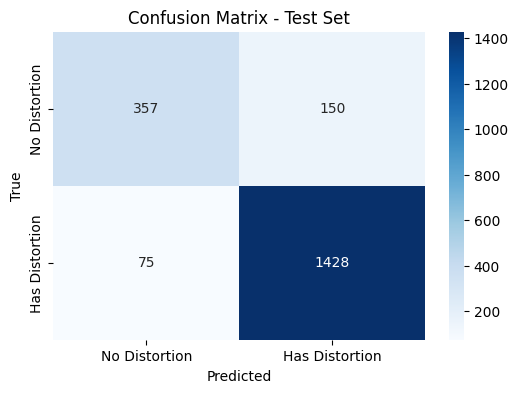

In [9]:
# Đánh giá trên test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=-1)
test_labels = test_results.label_ids

print("\nTest Results:")
print(f"Test Accuracy: {accuracy_score(test_labels, test_preds):.4f}")
print(f"Test Precision: {precision_score(test_labels, test_preds, average='binary', zero_division=0):.4f}")
print(f"Test Recall: {recall_score(test_labels, test_preds, average='binary', zero_division=0):.4f}")
print(f"Test F1-Score: {f1_score(test_labels, test_preds, average='binary', zero_division=0):.4f}")

# Vẽ confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Distortion', 'Has Distortion'], yticklabels=['No Distortion', 'Has Distortion'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
# Lưu model
trainer.save_model('/kaggle/working/phobert_detection')
tokenizer.save_pretrained('/kaggle/working/phobert_detection')

('/kaggle/working/phobert_detection/tokenizer_config.json',
 '/kaggle/working/phobert_detection/special_tokens_map.json',
 '/kaggle/working/phobert_detection/vocab.txt',
 '/kaggle/working/phobert_detection/bpe.codes',
 '/kaggle/working/phobert_detection/added_tokens.json')

In [11]:
!zip -r /kaggle/working/phobert_detection.zip /kaggle/working/phobert_detection


  adding: kaggle/working/phobert_detection/ (stored 0%)
  adding: kaggle/working/phobert_detection/added_tokens.json (stored 0%)
  adding: kaggle/working/phobert_detection/vocab.txt (deflated 55%)
  adding: kaggle/working/phobert_detection/special_tokens_map.json (deflated 57%)
  adding: kaggle/working/phobert_detection/training_args.bin (deflated 51%)
  adding: kaggle/working/phobert_detection/bpe.codes (deflated 59%)
  adding: kaggle/working/phobert_detection/tokenizer_config.json (deflated 77%)
  adding: kaggle/working/phobert_detection/model.safetensors (deflated 7%)
  adding: kaggle/working/phobert_detection/config.json (deflated 51%)


In [12]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('phobert_detection.zip')

/kaggle/working


/kaggle/working/phobert_detection.zip